# Setup & Load Data

In [1]:
from __future__ import unicode_literals
import pprint
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import sys
import random
import seaborn as sns
import matplotlib.font_manager as font_manager
sys.path.append('../')
from vistools.utils import *
from pytz import timezone
from matplotlib import font_manager, rc

# font setup
font_dirs = ['../']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
plt.rcParams['font.family'] = 'Times New Roman'

base_path = '../enertalk-dataset/'
psn = '00'
date = '20170118'


df = get_kr_oneday_aligned(base_path, psn, date)
df_agg = df
df_agg['timestamp'] = df_agg['timestamp'].apply(lambda x: x.replace(microsecond=0))
df_agg = df_agg.groupby('timestamp').mean()
df_agg = df_agg.reset_index()
df_agg['Standby power'] = np.min(df_agg['total'])
df_agg_00 = df_agg


psn = '12'
date = '20161207'
df = get_kr_oneday_aligned(base_path, psn, date)

df_agg = df
df_agg['timestamp'] = df_agg['timestamp'].apply(lambda x: x.replace(microsecond=0))
df_agg = df_agg.groupby('timestamp').mean()
df_agg = df_agg.reset_index()
df_agg['Standby power'] = np.min(df_agg['total'])
df_agg_12 = df_agg


{'TV', 'fridge', 'water-purifier', 'rice-cooker', 'total', 'washing-machine', 'microwave', 'kimchi-fridge'}
{'TV', 'fridge', 'water-purifier', 'rice-cooker', 'total', 'washing-machine', 'microwave', 'kimchi-fridge'}
{'TV', 'fridge', 'rice-cooker', 'total', 'washing-machine', 'kimchi-fridge'}
{'TV', 'fridge', 'rice-cooker', 'total', 'washing-machine', 'kimchi-fridge'}


# Visualize Figure 4. Data snippets of two houses

Traceback (most recent call last):
  File "/root/.pyenv/versions/3.6.3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/root/.pyenv/versions/3.6.3/lib/python3.6/site-packages/matplotlib/axes/_base.py", line 510, in <lambda>
    'units finalize', lambda: self._on_units_changed(scalex=True))
  File "/root/.pyenv/versions/3.6.3/lib/python3.6/site-packages/matplotlib/axes/_base.py", line 2042, in _on_units_changed
    self.autoscale_view(scalex=scalex, scaley=scaley)
  File "/root/.pyenv/versions/3.6.3/lib/python3.6/site-packages/matplotlib/axes/_base.py", line 2502, in autoscale_view
    'minposx', self.xaxis, self._xmargin, x_stickies, self.set_xbound)
  File "/root/.pyenv/versions/3.6.3/lib/python3.6/site-packages/matplotlib/axes/_base.py", line 2497, in handle_single_axis
    set_bound(x0, x1)
  File "/root/.pyenv/versions/3.6.3/lib/python3.6/site-packages/matplotlib/axes/_base.py", line 3097, in set_xbound
    self.set_

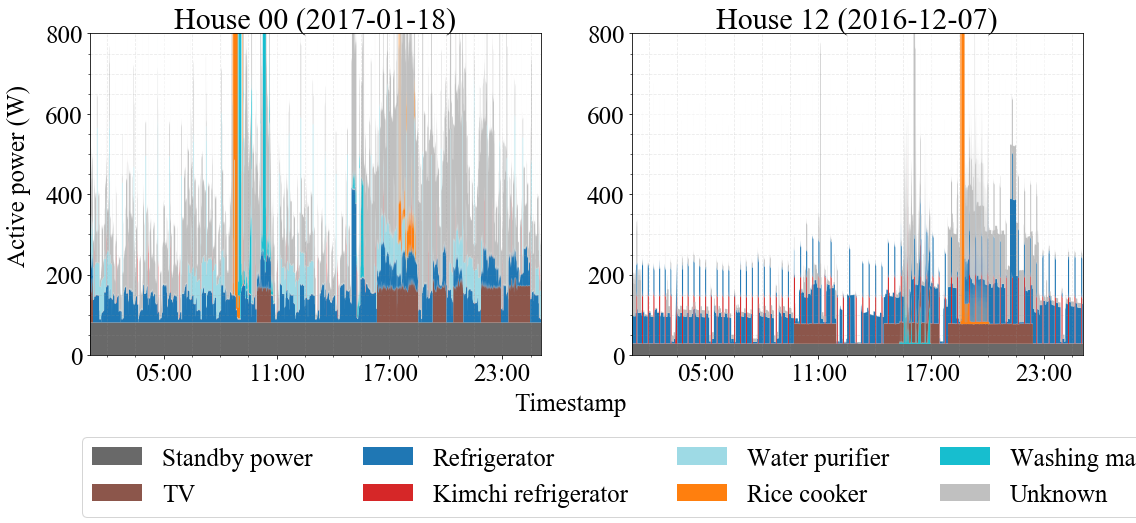

In [5]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
overall_fontsize = 25

nice_fonts = {
        "text.usetex": False,
        "axes.labelsize": overall_fontsize,
        "font.size": overall_fontsize,
        "legend.fontsize": overall_fontsize,
        "xtick.labelsize": overall_fontsize,
        "ytick.labelsize": overall_fontsize,
}

mpl.rcParams.update(nice_fonts)

font_dirs = ['../']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['font.family'] = 'Times New Roman'



fig_width = 8.9
golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
fig_height = fig_width*golden_mean/2 # height in inches

hours = mdates.HourLocator(interval = 6, tz = timezone('Asia/Seoul'))
h_fmt = mdates.DateFormatter('%H:%M', tz = timezone('Asia/Seoul'))

app_name_lst = list(df_agg.columns)
app_name_lst.remove('total')

timestamp = [ts.to_pydatetime().replace(tzinfo=timezone('Asia/Seoul')) for ts in df_agg_00['timestamp']]


#plt.figure(figsize = (fig_width, fig_height))
f, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=False,
                             figsize = (fig_width*2, fig_height*2.8))

ax1.xaxis.tick_bottom()
ax1.xaxis.set_major_locator(hours)
ax1.xaxis.set_major_formatter(h_fmt)

# House 00
cum = df_agg_00['Standby power']
ax1.fill_between(timestamp, np.zeros(df_agg_00.shape[0]), cum, label = 'Standby power', facecolor='dimgrey')

for app_name in ['TV', 'fridge', 'kimchi-fridge', 'water-purifier',\
                'rice-cooker','washing-machine']:
    lower = cum
    cum = cum + df_agg_00[app_name]
    app_color = get_app_color(app_name)
    ax1.fill_between(timestamp, lower, cum, label = get_pretty_name(app_name), facecolor=app_color)


ax1.fill_between(timestamp, cum, df_agg_00['total'], label = 'Unknown', facecolor = 'silver')
plt.margins(x=0, tight = True)


# House 12
hours = mdates.HourLocator(interval = 6, tz = timezone('Asia/Seoul'))
h_fmt = mdates.DateFormatter('%H:%M', tz = timezone('Asia/Seoul'))

cum = df_agg_12['Standby power']
timestamp = [ts.to_pydatetime().replace(tzinfo=timezone('Asia/Seoul')) for ts in df_agg_12['timestamp']]

ax2.fill_between(timestamp, np.zeros(df_agg_12.shape[0]), cum, label = 'Standby power', facecolor='dimgrey')

for app_name in ['washing-machine', 'TV', 'rice-cooker', 'kimchi-fridge', 'fridge']:
    lower = cum
    cum = cum + df_agg_12[app_name]
    app_color = get_app_color(app_name)
    ax2.fill_between(timestamp, lower, cum, label = get_pretty_name(app_name), facecolor=app_color)
ax2.fill_between(timestamp, cum, df_agg_12['total'], label = 'Unknown', facecolor = 'silver')



ax2.xaxis.tick_bottom()
ax2.xaxis.set_major_locator(hours)
ax2.xaxis.set_major_formatter(h_fmt)


handles, labels = ax1.get_legend_handles_labels()
lgd = f.legend(handles, labels, loc='lower center',ncol=4, bbox_to_anchor=(0.5, 0.01), borderaxespad=0.)

ax1.grid(b=True, which='major', color='#999999', linestyle='--', alpha = 0.1)
ax2.grid(b=True, which='major', color='#999999', linestyle='--', alpha = 0.1)
ax1.minorticks_on()
ax2.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='--', alpha=0.2)
ax2.grid(b=True, which='minor', color='#999999', linestyle='--', alpha=0.2)
ax1.set_ylim([0,800])
ax2.set_ylim([0,800])

ax1.set_title('House 00 (2017-01-18)')
ax2.set_title('House 12 (2016-12-07)')
ax1.margins(x=0, tight = True)
ax2.margins(x=0, tight = True)
f.text(0.5, 0.2, 'Timestamp', ha='center')
f.text(0.07, 0.625, 'Active power (W)', ha='center', va='center', rotation='vertical')
f.subplots_adjust(bottom=0.3)


ax1.set_xticks([datetime.datetime(2017,1,17,20,0,0),
                  datetime.datetime(2017,1,18,2,0,0),
                  datetime.datetime(2017,1,18,8,0,0),
               datetime.datetime(2017,1,18,14,0,0)])

ax2.set_xticks([datetime.datetime(2016,12,6,20,0,0),
                  datetime.datetime(2016,12,7,2,0,0),
                  datetime.datetime(2016,12,7,8,0,0),
               datetime.datetime(2016,12,7,14,0,0)])
f.show()
f.savefig('../plots/data_snippet_houses.eps', bbox_tight=True, format='eps', dpi=300)